In [1]:
#Imports
import pandas as pd
import numpy as np
from skimage.io import imread
import skimage

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
drive_and_label = pd.read_excel('Spectogram_Data_v1.xlsx')
drive_and_label.head()

,Spectogram,Meta_Label,New_Label
0,https://drive.google.com/uc?export=download&id...,320kpbs,192 kbps (LAME)
1,https://drive.google.com/uc?export=download&id...,320 kbps,320 kbps (LAME)
2,https://drive.google.com/uc?export=download&id...,320 kbps,128 kbps (CBR)
3,https://drive.google.com/uc?export=download&id...,128 kbps,128 kpbs (AAC)
4,https://drive.google.com/uc?export=download&id...,320 kbps,128 kbps (LAME)


In [ ]:
drive_and_label.iloc[0]['Spectogram']

In [ ]:
im = imread('https://drive.google.com/uc?export=download&id=1xyNHbQEGoqfgWsVl8algfpX5EdQdrqEm', as_grey = True)

## Calculating 'score' by picture
Here we are giving an overall score to each picture. We are trying to get an overall sense of how many black pixels there are. We are also trying to locate the shelf.

In [6]:
d = {}

for idx, row in drive_and_label.iterrows():
    #Find picture from GD link
    im = imread(row['Spectogram'], as_grey = True)

    #Crop Picture to get rid of top section
    #50 pixels is the standard header
    im = im[49:]

    #Find Bounds of image (to give baseline)
    y_bound, x_bound = im.shape

    #Looping across the x-axis (predefined resolution)
    score = []
    temp = 0
    for ii in range(0, y_bound):
        #If the sum of the pixels across the row is 
        if sum(im[ii]) != 0:
            temp += 1
            score.append(temp)
        #If the sum is 0 we give a bad score
        elif sum(im[ii]) == 0:
            temp -= 1
            score.append(temp)

    d[idx] = score 

## Converting Spectograms to CIFAR-10 Dataset (OUTDATED)


Our goal here is to take each spectogram and turn its picture into raw  data. Each column corresponds to color values of each pixel of the image (after the first column, which is the label). Each of our pictures are cropped to only the spectograph which i

This data is concidered raw because it simply encodes the image itself. We are going to be use different types of encoding such as DAISY and a Color Histogram.

In [ ]:
#https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image/39382475
def crop_center(img,cropx,cropy):
    y,x,z = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2) 
    return img[starty:starty+cropy,startx:startx+cropx]

In [ ]:
d = {}
#Loop through each Google Drive link
for idx, row in drive_and_label.iterrows():
    
    #Creating a 2-D Array with just pixel values
    #print ('Finding feature array...')
    im = imread(row['Spectogram'])
    im_crop = crop_center(im, 505, 295)
    features = im_crop.flatten()
    #print('... array found.')
    
    #Adding features to dictionary 
    d[idx] = features

In [26]:
df = pd.DataFrame.from_dict(d)
df = df.T
df.insert(0, 'label', drive_and_label['New_Label'])
df.tail()

df.to_csv('SCORE.csv', sep = ',')

True

### Now we have to reduce the size of the dataset.

Before we were at a sparse matrix of (5,446926), now we have a more dense matrix at (5,~8000).

In [ ]:
backup_df = df

In [ ]:
#No need for columns that are identical (all 0 values)
df = df.loc[:, (df != 0).any(axis=0)]

# Machine Learning (Finally)

thoughts on why it's low:
- crowd source sorting
- too hard of a problem
- not enough training data

In [ ]:
#This is raw encoding
raw_df = df
raw_df.tail()

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scalar = StandardScaler()

In [9]:
#Finding and converting raw data
rawY = df.iloc[0:799, 0].values
rawX = df.iloc[0:799, 1:].values
scalar.fit(rawX)
rawX = scalar.transform(rawX)

#Finding and converting test data
rawY_test = df.iloc[800:, 0].values
rawX_test = df.iloc[800:, 1:].values

scalar.fit(rawX_test)
rawX_test = scalar.transform(rawX_test)

C:\Users\Tom Slesinger\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

classifier = DummyClassifier(strategy='most_frequent')
classifier.fit(rawX, rawY)

print("Training accuracy: %0.6f" % accuracy_score(rawY, classifier.predict(rawX)))
print("Testing accuracy: %0.6f" % accuracy_score(rawY_test, classifier.predict(rawX_test)))

Training accuracy: 0.138924
Testing accuracy: 0.127168


## K-Fold Cross Validation

In [11]:
#Finding and converting raw data
Y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values
scalar.fit(X)
X = scalar.transform(X)

#Finding and converting test data
Y_test = df.iloc[800:, 0].values
X_test = df.iloc[800:, 1:].values

scalar.fit(X_test)
X_test = scalar.transform(X_test)

C:\Users\Tom Slesinger\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

LR: 0.145971 (0.045442)
KNN: 0.093467 (0.037930)
TREE: 0.145971 (0.045442)
SVM: 0.136693 (0.043746)


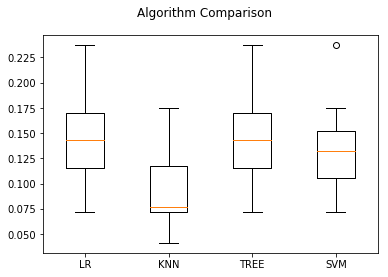

In [13]:
# prepare configuration for cross validation test harness
seed = 123
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [14]:
from sklearn.svm import SVC

switch = False
for kernel in ['linear', 'poly', 'poly', 'rbf']:
    print('--- Using a {} kernel ---'.format(kernel))
    for c_iter in [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]:
        #Init Classifier given kernel
        if kernel == 'poly' and switch == False:
            classifier = SVC(kernel=kernel, degree = 2, C=c_iter, random_state=123)
            if c_iter == 1000.0:
                switch = True #done with first poly move to second
        elif kernel == 'poly' and switch == True:
            classifier = SVC(kernel=kernel, degree = 3, C=c_iter, random_state=123)
        else:
            classifier = SVC(kernel=kernel, C=c_iter, random_state=123)
        
        #Fit classifier
        classifier.fit(rawX, rawY)
        
        #Find Accuracy
        print('C = {}'.format(c_iter))
        #print("Training accuracy: %0.6f" % accuracy_score(rawY[:1000], classifier.predict(rawX[:1000])))
        print("Test accuracy: %0.6f" % accuracy_score(rawY_test, classifier.predict(rawX_test)))

--- Using a linear kernel ---
C = 0.0001
Test accuracy: 0.127168
C = 0.001
Test accuracy: 0.127168
C = 0.01
Test accuracy: 0.127168
C = 0.1
Test accuracy: 0.127168
C = 1.0
Test accuracy: 0.127168
C = 10.0
Test accuracy: 0.127168
C = 100.0
Test accuracy: 0.127168
C = 1000.0
Test accuracy: 0.127168
--- Using a poly kernel ---
C = 0.0001
Test accuracy: 0.127168
C = 0.001
Test accuracy: 0.127168
C = 0.01
Test accuracy: 0.127168
C = 0.1
Test accuracy: 0.127168
C = 1.0
Test accuracy: 0.127168
C = 10.0
Test accuracy: 0.127168
C = 100.0
Test accuracy: 0.127168
C = 1000.0
Test accuracy: 0.127168
--- Using a poly kernel ---
C = 0.0001
Test accuracy: 0.127168
C = 0.001
Test accuracy: 0.127168
C = 0.01
Test accuracy: 0.127168
C = 0.1
Test accuracy: 0.127168
C = 1.0
Test accuracy: 0.127168
C = 10.0
Test accuracy: 0.127168
C = 100.0
Test accuracy: 0.127168
C = 1000.0
Test accuracy: 0.127168
--- Using a rbf kernel ---
C = 0.0001
Test accuracy: 0.127168
C = 0.001
Test accuracy: 0.127168
C = 0.01
Test 

## Decision Tree

In [15]:
#Finding and converting raw data
Y = df.iloc[:799, 0].values
X = df.iloc[:799, 1:].values
scalar.fit(X)
X = scalar.transform(X)

#Finding and converting test data
Y_test = df.iloc[800:, 0].values
X_test = df.iloc[800:, 1:].values

scalar.fit(X_test)
X_test = scalar.transform(X_test)

C:\Users\Tom Slesinger\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
from sklearn.tree import DecisionTreeClassifier

for depth in [3,8,14,100]:
    for leaf in [1,5,10,15,50]:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=123)
        tree.fit(X, Y)
        print('Depth of {} leaf sample of {}'.format(depth, leaf))
        print("Training accuracy: %0.6f" % accuracy_score(Y, tree.predict(X)))
        print("Test accuracy: %0.6f" % accuracy_score(Y_test, tree.predict(X_test)))

Depth of 3 leaf sample of 1
Training accuracy: 0.150188
Test accuracy: 0.127168
Depth of 3 leaf sample of 5
Training accuracy: 0.150188
Test accuracy: 0.127168
Depth of 3 leaf sample of 10
Training accuracy: 0.138924
Test accuracy: 0.127168
Depth of 3 leaf sample of 15
Training accuracy: 0.138924
Test accuracy: 0.127168
Depth of 3 leaf sample of 50
Training accuracy: 0.138924
Test accuracy: 0.127168
Depth of 8 leaf sample of 1
Training accuracy: 0.150188
Test accuracy: 0.127168
Depth of 8 leaf sample of 5
Training accuracy: 0.150188
Test accuracy: 0.127168
Depth of 8 leaf sample of 10
Training accuracy: 0.138924
Test accuracy: 0.127168
Depth of 8 leaf sample of 15
Training accuracy: 0.138924
Test accuracy: 0.127168
Depth of 8 leaf sample of 50
Training accuracy: 0.138924
Test accuracy: 0.127168
Depth of 14 leaf sample of 1
Training accuracy: 0.150188
Test accuracy: 0.127168
Depth of 14 leaf sample of 5
Training accuracy: 0.150188
Test accuracy: 0.127168
Depth of 14 leaf sample of 10
Tr

In [17]:
from sklearn.ensemble import RandomForestClassifier

for iter_ in [10,50,100,300]:
    r_tree = RandomForestClassifier(n_estimators=iter_, max_depth=8, min_samples_leaf=15, random_state=123)
    r_tree.fit(X, Y)
    print('Training with {} number of decision trees.'.format(iter_))
    #print("Training accuracy: %0.6f" % accuracy_score(Y[:5000], r_tree.predict(X[:5000])))
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, r_tree.predict(X_test)))

C:\Users\Tom Slesinger\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Training with 10 number of decision trees.
Test accuracy: 0.127168
Training with 50 number of decision trees.
Test accuracy: 0.127168
Training with 100 number of decision trees.
Test accuracy: 0.127168
Training with 300 number of decision trees.
Test accuracy: 0.127168


## Neural Network

In [18]:
from sklearn.neural_network import MLPClassifier
for HL_1 in [50,100,200,300]:
    multi = MLPClassifier(hidden_layer_sizes=(HL_1), random_state=123)
    multi.fit(X, Y)
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, multi.predict(X_test)))

Test accuracy: 0.086705
Test accuracy: 0.127168
Test accuracy: 0.086705
Test accuracy: 0.127168


## Daisy Features

In [ ]:
from skimage.color import rgb2gray
from skimage.feature import daisy as daisy_feature
from skimage import data

In [ ]:
daisy_dict = {}
#Loop through each Google Drive link
for idx, row in drive_and_label.iterrows():
    
    #Creating a Array with just pixel values
    print ('Finding feature array...')
    im = imread(row['Spectogram'])
    im_crop = crop_center(im, 505, 295)
    
    #Convert image to grayscale
    gray = rgb2gray(im_crop)
    
    #Convert grayscale to Daisy features
    daisy_f = daisy_feature(gray)
    features = daisy_f.flatten()
    print('... array found.')
    
    #Adding features to dictionary 
    daisy_dict[idx] = features

In [ ]:
len(daisy_dict.pop(1))

In [ ]:
#Converting daisy dict into dataframe
daisy_df = pd.DataFrame.from_dict(daisy_dict)
daisy_df = daisy_df.T
daisy_df.insert(0, 'label', drive_and_label['New_Label'])
daisy_df.tail()

In [ ]:
#Finding and converting raw data
Y = daisy_df.iloc[:799, 0].values
X = daisy_df.iloc[:799, 1:].values
scalar.fit(X)
X = scalar.transform(X)

#Finding and converting test data
Y_test = daisy_df.iloc[800:, 0].values
X_test = daisy_df.iloc[800:, 1:].values

scalar.fit(X_test)
X_test = scalar.transform(X_test)